In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Hyper-parameters

In [41]:
n_epochs = 2
batch_size = 32
learning_rate = 0.001

In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Set train and test datasets

In [43]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./CIFAR10/data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./CIFAR10/data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


## Dataloaders

In [44]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
classes = ('plane', 'car', 'brid', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Model

In [46]:
# Input size is 3 because we will send 3 types of color channels
input_size = 3
output_size = 6
kernel_size = 5

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Feature learning
        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(output_size, 16, kernel_size)
        # Classification
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = ConvNet()

## Loss function

In [47]:
# CrossEntropyLoss Includes the softmax
criterion = nn.CrossEntropyLoss()

## Optimizer

In [48]:
optimzer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## TensorBoard setup

In [49]:
tb = SummaryWriter()

In [50]:
# Helper function
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

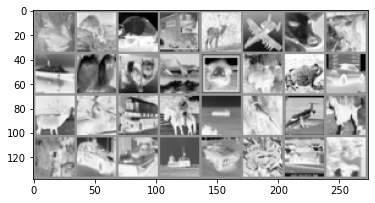

In [51]:
# Get random training images
dataiter = iter(train_dl)
images, labels = dataiter.next()

# Create grid of images
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)

tb.add_image('Before_traning_images', img_grid)
tb.close()

In [52]:
# def select_n_random(data, labels, n=100):
#     '''
#     Selects n random datapoints and their corresponding labels from a dataset
#     '''
#     assert len(data) == len(labels)

#     perm = torch.randperm(len(data))

#     return data[perm][:n], labels[perm][:n]

# # select random images and their target indices
# images, labels = select_n_random(torch.tensor(train_dataset.data), torch.tensor(train_dataset.targets))

# # get the class labels for each image
# class_labels = [classes[lab] for lab in labels]

# print(labels.shape)
# print(len(class_labels))

# print(images.shape)
# # log embeddings
# features = images.reshape(-1, 3*32*32)

# print(features.shape)


# i = images.unsqueeze(1)
# print(f"i shape: {i.shape}")
# print(type(i))

# tb.add_embedding(features,
#                     metadata=class_labels,
#                     label_img=images.unsqueeze(1))
# tb.close()

In [53]:
# helper function
# def select_n_random(data, labels, n=100):
#     assert len(data) == len(labels)

#     data = data [:, :n]
#     labels = labels[:n]

#     return data, labels
    # perm = torch.randperm(len(data))
    # print(perm)
    # print(type(data[perm][:n]))
    # print(type(labels))
    # return data[perm][:n], labels[perm][:n]

In [54]:
# images, labels = select_n_random(train_dataset.data, train_dataset.targets)

# class_labels = [classes[lab] for lab in labels]

# # features = images.view(-1, 28 * 28)
# tb.add_embedding(images,
#                     metadata=class_labels,
#                     label_img=images.unsqueeze(1))
# tb.close()

In [55]:
# helper functions
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## Hook

In [56]:
def activation_hook(inst, inp, out):
    """Run activation hook
    

    Parameters
    ----------
    inst : torch.nn.Module
        The layer we want to attach the hook to.
    inp : torch.Tensor
        The input to the `forward` method.
    out : torch.Tensor
        The output of the `forward` method.
    """
    # print('activation')
    tb.add_histogram(repr(inst), out)

    # act = out.detach().squeeze()
    # fig, axarr = plt.subplots(act.size(0))
    # for idx in range(act.size(0)):
    #     axarr[idx].imshow(act[idx])

    # img_grid = torchvision.utils.make_grid(out)

    # matplotlib_imshow(img_grid, one_channel=True)

    # tb.add_image('Output images', img_grid)

model.fc1.register_forward_hook(activation_hook)
model.fc2.register_forward_hook(activation_hook)
model.fc3.register_forward_hook(activation_hook)

## Train model

In [57]:
n_total_steps = len(train_dl)

for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_dl):
        # Forward
        output = model(images)

        # Loss
        loss = criterion(output, labels)

        # Backward
        optimzer.zero_grad()
        loss.backward()
        # Update the parameters
        optimzer.step()

        if (i+1) % 1000 == 0:
            print(f"epoch: {epoch+1}/{n_epochs}, step: {i+1}/{n_total_steps}, loss: {loss.item():.4f}")
        
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            tb.add_scalar('training loss',
                            loss.item() / 1000,
                            epoch * len(train_dl) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            tb.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, images, labels),
                            global_step=epoch * len(train_dl) + i)

epoch: 1/2, step: 1000/1563, loss: 1.5355
epoch: 2/2, step: 1000/1563, loss: 1.3387


## Validate model

In [58]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]

    for images, labels in test_dl:
        output = model(images)

        # Return value and index 
        _, predictions = torch.max(output, 1)

        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predictions[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    acc = 100 * n_correct / n_samples
    print(f"Accuracy of CNN: {acc}")

    for i in range(10):
        acc = 100 * n_class_correct[i] / n_class_samples[i]
        print(f"Accuracy of {classes[i]}: {acc}")

IndexError: index 16 is out of bounds for dimension 0 with size 16